# CNN with EfficientNet and transfer learning of pretrained weights

Goals in this notebook:
- Training dataset on a configuration of CNN using EfficientNet. This pipe will be built for subset of 1912 images first (balanced dataset), but will later be applied to our real training dataset (also balanced).
    - we'll make a fixed number of end layers trainable; the rest of parameters in the front layers will be frozen.
- High-level comparison of different EfficientNets and weights on validation metrics.
- On the best EfficientNet, do some hyperparmater tuning using `optuna` on post-transfer-learning dense layers, optimizing for AUC
    - Maybe also hyperparameter tune the # of layers in EfficientNet that's made trainable?


In [ ]:
!pip install optuna
!pip install tensorflow-addons

In [2]:
import joblib

import tensorflow as tf
import tensorflow_addons as tfa
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import constants
import lesion_data

/usr/local/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


## Load dataset

Here, I'm using a subbset of training data, which is a balanced dataset of all 8 classes, with 239 images each. I won't be using validation data yet (TBD).

In [4]:
random_seed = 21

train_ds = tf.keras.utils.image_dataset_from_directory(
    constants.get_training_augmented_path(),
    validation_split=0.1,
    subset="training",  # Note: since this is proof of concept, this is fine, but validation set should be unaugmented
    seed=random_seed,
    image_size=(224, 224),  # chosen size based on what's common in industry
    batch_size=32,  # default
    label_mode='categorical',
    shuffle=True,  # default
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    constants.get_training_augmented_path(),
    validation_split=0.1,
    subset="validation",  # Note: since this is proof of concept, this is fine, but validation set should be unaugmented
    seed=random_seed,
    image_size=(224, 224),  # chosen size based on what's common in industry
    batch_size=32,  # default
    label_mode='categorical',
    shuffle=True,  # default
)

Found 1912 files belonging to 8 classes.
Using 1721 files for training.
Found 1912 files belonging to 8 classes.
Using 191 files for validation.


#### Choosing the same metrics for evaluation

In [98]:
tf.keras.backend.clear_session()
metrics = [
    "accuracy",
    tf.metrics.Precision(name="precision"),
    tf.metrics.Recall(name="recall"),
    tf.keras.metrics.AUC(curve="PR", name="auc_pr"),
    tf.keras.metrics.AUC(curve="ROC", name="auc_roc"),
    tfa.metrics.F1Score(num_classes=8, name="f1_score"),
]

# For quality of life
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        mark = "*"
        if epoch % 10 == 9:
            mark = "*|"
        print(mark, end="")
        
    # def on_train_end(self, logs=None):
    #     keys = list(logs.keys())
    #     print("\nStop training; got log keys: {}".format(keys))

def plot_history_df(history_df: pd.DataFrame):
    x_arr = np.arange(len(history_df['loss'])) + 1

    fig = plt.figure(figsize=(18, 9))
    for i, metric in enumerate(["loss", "accuracy", "precision", "recall", "auc_pr", "auc_roc"]):
        ax = fig.add_subplot(2, 3, i+1)
        ax.plot(x_arr, history_df[metric], '-', label=f'Train {metric}')
        ax.plot(x_arr, history_df[f'val_{metric}'], '--', label=f'Validation {metric}')
        ax.legend(fontsize=10)
        ax.set_xlabel('Epoch', size=15)
        ax.set_ylabel(metric, size=15)

## Building model

The EfficientNet-based CNN model will have the following elements:

1. EfficientNet -- first need to figure out which one
    1. _**A**_: trainable parameters, increment of 500,000
1. _**G**_ layers of Dense (choose between 0 and 4 layers; another `Sequential`)
    1. _**H**_ units (choose 5 to 30)
    1. Activation: relu
    1. Dropout - 0.1
1. One output layer of Dense
    1. output units: 8
    1. Activation: softmax
    
Next, I'll build a simple version of EfficientNet model, just to get a feel for how to set it up. According to [this guide from Keras](https://keras.io/guides/transfer_learning/), we should develop our top layer (Dense layers after pretrained layer) first while keeping pretrained weights frozen. After that's done, only then we unfreeze all or some of the weights in the pretrained layer at a _small learning rate_ for fine-tuning.

In [67]:
IMG_SHAPE = (224, 224, 3)

# light augmentation on balanced data
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomFlip("vertical"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

tf.keras.backend.clear_session()
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB0(
    weights="imagenet",
    pooling="max",
    include_top=False,
)

# Making all of it not trainable
efficientnet_model.trainable = False


total_dense_layers = 2
dense_units = 10

dropout_rate = 0.1

dense_layers = tf.keras.models.Sequential(name="dense_layers")
for dense_layer_num in range(total_dense_layers):
    dense_layers.add(
        tf.keras.layers.Dense(
            dense_units,
            activation="relu",
            name=f"Dense_{dense_layer_num}",
        )
    )
    dense_layers.add(
        tf.keras.layers.Dropout(dropout_rate, name=f"dense_dropout_{dense_layer_num}")
    )
    dense_layers.add(
        tf.keras.layers.BatchNormalization()
    )

# putting it altogether
inputs = tf.keras.Input(shape=IMG_SHAPE)

x = data_augmentation(inputs)
x = efficientnet_model(x) # EfficientNet with ImageNet weights
x = dense_layers(x) # Dense layers

outputs = tf.keras.layers.Dense(8, activation="softmax")(x) # Classification layer

model = tf.keras.Model(inputs, outputs)

In [68]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense_layers (Sequential)    (None, 10)                13000     
_________________________________________________________________
dense (Dense)                (None, 8)                 88        
Total params: 4,062,659
Trainable params: 13,048
Non-trainable params: 4,049,611
_________________________________________________________________


In [69]:
model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=metrics,
)

In [70]:
# Fit it
callbacks = [CustomCallback(), tf.keras.callbacks.EarlyStopping(monitor='val_auc_pr', patience=10, mode='max')]
tf.keras.backend.clear_session()
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
history = model.fit(
    train_ds,
    validation_data=validation_ds,  # NOTE: validation data should be sourced from somewhere else, need to change
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=0,
)
print("\ndone training")

grand_history = history.history

**********|**********|**********|**********|**********|
Stop training; got log keys: ['loss', 'accuracy', 'precision', 'recall', 'auc_pr', 'auc_roc', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc_pr', 'val_auc_roc', 'val_f1_score']

done training


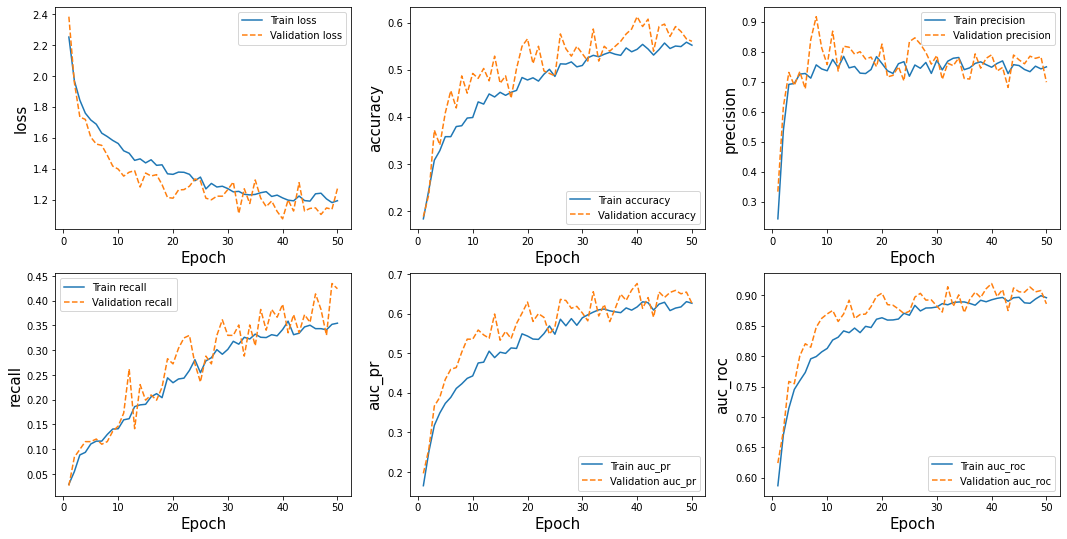

In [71]:
# View history
plot_history_df(pd.DataFrame(history.history))

#### Fine-tuning

Now once we have our dense layer trained, we proceed to fine-tuning of EfficientNet. We'll need to now use a very low learning rate in our compiler.

In [76]:
# Making the last 1 million parameters trainable; others frozen/not trainable
efficientnet_model.trainable = True

target_trainable_params = 2e6  # arbitrary
trainable_params_left = target_trainable_params
for layer in reversed(efficientnet_model.layers):  # Go from bottom
    if trainable_params_left > 0:
        trainable_params_left -= layer.count_params()
        layer.trainable = True
    else:
        layer.trainable = False

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense_layers (Sequential)    (None, 10)                13000     
_________________________________________________________________
dense (Dense)                (None, 8)                 88        
Total params: 4,062,659
Trainable params: 2,008,408
Non-trainable params: 2,054,251
_________________________________________________________________


In [77]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    metrics=metrics,
)

In [78]:
# Fit it
callbacks = [
    CustomCallback(),
    tf.keras.callbacks.EarlyStopping(monitor='val_auc_pr', patience=50, mode='max'),
]
tf.keras.backend.clear_session()
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
history_finetune = model.fit(
    train_ds,
    validation_data=validation_ds,  # NOTE: validation data should be sourced from somewhere else, need to change
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=0,
)
print("done training")

**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|
Stop training; got log keys: ['loss', 'accuracy', 'precision', 'recall', 'auc_pr', 'auc_roc', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc_pr', 'val_auc_roc', 'val_f1_score']
done training


In [82]:
for m in grand_history.keys():
    grand_history[m] += history_finetune.history[m]

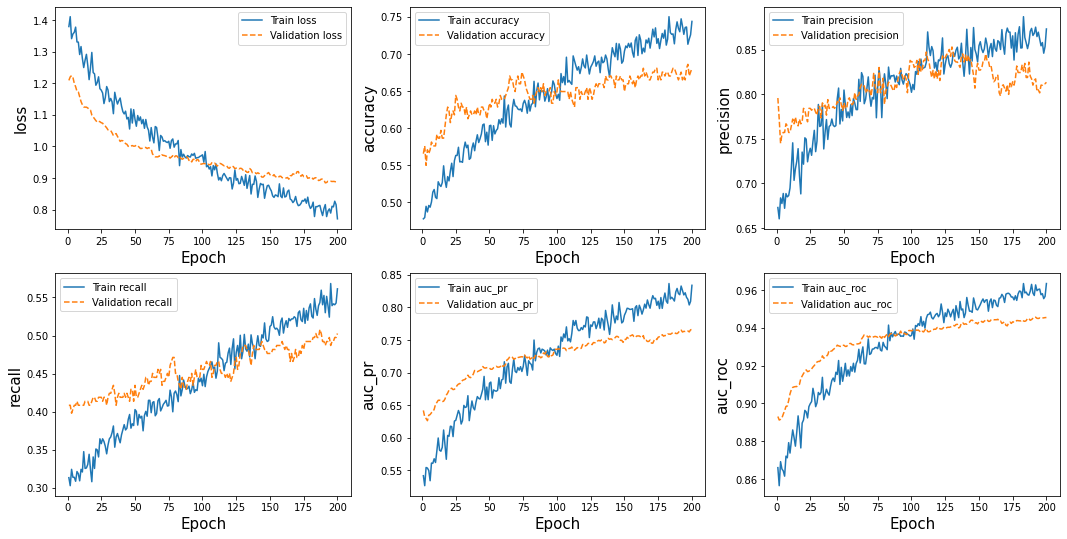

In [79]:
plot_history_df(pd.DataFrame(history_finetune.history))

In [84]:
# Try saving model
model.save("saved_models/cnn_efficientnet/efficientnet0_model.h5")

/usr/local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [86]:
pd.DataFrame(grand_history).to_csv("saved_models/cnn_efficientnet/efficientnet0_model_history.csv")

In [85]:
!ls saved_models/cnn_efficientnet -lah

total 84M
drwxr-xr-x 3 root root 6.0K Nov 18 09:00 .
drwxr-xr-x 5 root root 6.0K Nov 14 01:04 ..
drwxr-xr-x 2 root root 6.0K Nov 14 02:55 .ipynb_checkpoints
-rw-r--r-- 1 root root  25M Nov 14 01:44 best_en_model.h5
-rw-r--r-- 1 root root 4.8K Nov 14 03:42 best_en_model_history.csv
-rw-r--r-- 1 root root  28M Nov 14 03:48 best_en_tuned_model.h5
-rw-r--r-- 1 root root 7.2K Nov 14 03:48 best_en_tuned_model_history.csv
-rw-r--r-- 1 root root  32M Nov 18 09:00 efficientnet0_model.h5
-rw-r--r-- 1 root root  15K Nov 14 03:55 no-name-431d0280-4cde-4f72-9cf5-47cf18d215eb.pkl


^ The model size is quite big. Let's be careful about what model to save and what to commit to git.

## Comparison between various versions of EfficientNet



In [89]:
IMG_SHAPE = (224, 224, 3)

verbose=False
best_model = None
best_auc = -1

for en_model_class in [
    tf.keras.applications.efficientnet.EfficientNetB0,
    tf.keras.applications.efficientnet.EfficientNetB1,
    tf.keras.applications.efficientnet.EfficientNetB2,
    tf.keras.applications.efficientnet.EfficientNetB3,
    tf.keras.applications.efficientnet.EfficientNetB4,
    tf.keras.applications.efficientnet.EfficientNetB5,
    tf.keras.applications.efficientnet.EfficientNetB6,
    tf.keras.applications.efficientnet.EfficientNetB7,
]:
    tf.keras.backend.clear_session()
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)
    
    efficientnet_model = en_model_class(
        weights="imagenet",
        pooling="max",
        include_top=False,
    )
    
    # Freezing the pre-trained model first in comparisons
    efficientnet_model.trainable = False

    # # Making the last 1 million parameters trainable; others frozen/not trainable
    # target_trainable_params = 1e6  # arbitrary
    # trainable_params_left = target_trainable_params
    # for layer in reversed(efficientnet_model.layers):  # Go from bottom
    #     if trainable_params_left > 0:
    #         trainable_params_left -= layer.count_params()
    #         layer.trainable = True
    #     else:
    #         layer.trainable = False

    total_dense_layers = 2
    dense_units = 10

    dropout_rate = 0.1

    dense_layers = tf.keras.models.Sequential(name="dense_layers")
    for dense_layer_num in range(total_dense_layers):
        dense_layers.add(
            tf.keras.layers.Dense(
                dense_units,
                activation="relu",
                name=f"Dense_{dense_layer_num}",
            )
        )
        dense_layers.add(
            tf.keras.layers.Dropout(dropout_rate, name=f"dense_dropout_{dense_layer_num}")
        )
        dense_layers.add(
            tf.keras.layers.BatchNormalization()
        )

    # putting it altogether
    inputs = tf.keras.Input(shape=IMG_SHAPE)

    x = efficientnet_model(inputs) # EfficientNet with ImageNet weights
    x = dense_layers(x) # Dense layers

    outputs = tf.keras.layers.Dense(8, activation="softmax")(x) # Classification layer

    model = tf.keras.Model(inputs, outputs)
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer="adam",
        metrics=metrics,
    )
    
    # Fit
    callbacks = [CustomCallback(), tf.keras.callbacks.EarlyStopping(monitor='val_auc_pr', patience=10, mode='max')]  # stop when not improving
    history = model.fit(
        train_ds,
        validation_data=validation_ds,  # NOTE: validation data should be sourced from somewhere else, need to change
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        verbose=int(verbose),
    )
    last_auc = history.history["val_auc_pr"][-1]
    
    # Print results
    print(
        f"Completed training on {en_model_class.__name__}, "
        + f"total {len(history.history['loss'])} epochs, "
        + f"val_auc_pr: {last_auc:.4f}"
    )
    # Save history regardless if it's good
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(f"saved_models/cnn_efficientnet/discovery_{en_model_class.__name__}_history.csv")
    
    # Save model if it's the best
    if last_auc > best_auc:
        best_auc = last_auc
        if verbose:
            print(f"New {best_auc=}")
        best_model = model
        best_model.save("saved_models/cnn_efficientnet/best_en_model.h5")
        history_df.to_csv("saved_models/cnn_efficientnet/best_en_model_history.csv")


**********|**********|**********|********
Stop training; got log keys: ['loss', 'accuracy', 'precision', 'recall', 'auc_pr', 'auc_roc', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc_pr', 'val_auc_roc', 'val_f1_score']
Completed training on EfficientNetB0, total 38 epochs, val_auc_pr: 0.5757
**********|**********|**********|*
Stop training; got log keys: ['loss', 'accuracy', 'precision', 'recall', 'auc_pr', 'auc_roc', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc_pr', 'val_auc_roc', 'val_f1_score']
Completed training on EfficientNetB1, total 31 epochs, val_auc_pr: 0.5196
**********|**********|**********|**********|***
Stop training; got log keys: ['loss', 'accuracy', 'precision', 'recall', 'auc_pr', 'auc_roc', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc_pr', 'val_auc_roc', 'val_f1_score']
Completed training on EfficientNetB2, total 43 epochs, val_auc_pr: 0.5821
**********|**********|*

In [90]:
best_model.layers[1].name

'efficientnetb4'

Evaluation of training

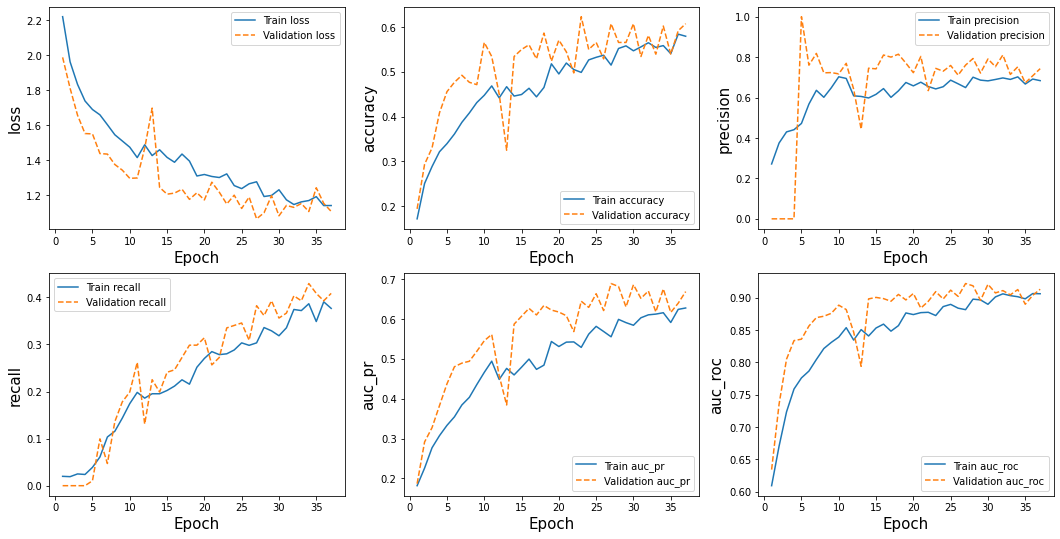

In [93]:
hist = pd.read_csv("saved_models/cnn_efficientnet/discovery_EfficientNetB4_history.csv")
plot_history_df(hist)

## Using [optuna](https://optuna.org/) for hyperparameter tuning

We will set up the model as something that can be manipulated by optuna, then run say 100 trials to figure out the best hyperparameters on our dataset.

In [ ]:
# Parameterize our entire model
verbose=False
IMG_SHAPE = (224, 224, 3)

best_model = None
best_auc = -1

def build_and_compile_model_optuna(trial):
    
    tf.keras.backend.clear_session()
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)
    
    # EfficientNet
    en_model_class = tf.keras.applications.efficientnet.EfficientNetB4
    efficientnet_model = en_model_class(
        weights="imagenet",
        pooling="max",
        include_top=False,
    )
    
    # Freezing the pre-trained model first in comparisons
    efficientnet_model.trainable = False

    # # Making the last X parameters trainable; others frozen/not trainable
    # target_trainable_params = trial.suggest_int("trainable_params_increment", 2, 5) * 5e5  # increments of 500,000
    # trainable_params_left = target_trainable_params
    # for layer in reversed(efficientnet_model.layers):  # Go from bottom
    #     if trainable_params_left > 0:
    #         trainable_params_left -= layer.count_params()
    #         layer.trainable = True
    #     else:
    #         layer.trainable = False

    # Dense
    dropout_rate = 0.1
    dense_layers = tf.keras.models.Sequential(name="dense_layers")
    for dense_layer_num in range(trial.suggest_int("total_dense_layers", 0, 4)):
        dense_layers.add(
            tf.keras.layers.Dense(
                trial.suggest_int(f"dense_layer_{dense_layer_num}_dense_units", 5, 30),
                activation="relu",
                name=f"Dense_{dense_layer_num}",
            )
        )
        dense_layers.add(
            tf.keras.layers.Dropout(dropout_rate, name=f"dense_dropout_{dense_layer_num}")
        )
        dense_layers.add(
            tf.keras.layers.BatchNormalization()
        )

    # putting it altogether
    inputs = tf.keras.Input(shape=IMG_SHAPE)

    x = efficientnet_model(inputs) # EfficientNet with ImageNet weights
    x = dense_layers(x) # Dense layers

    outputs = tf.keras.layers.Dense(8, activation="softmax")(x) # Classification layer

    model = tf.keras.Model(inputs, outputs)
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer="adam",
        metrics=metrics,
    )

    return model

# Define an objective function to be maximized.
def objective(trial):
    tf.keras.backend.clear_session()
    
    global best_auc
    global best_model
    if verbose:
        print(f"Current {best_auc=}")
    model = build_and_compile_model_optuna(trial)
    random_seed = 21

    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)
    # Fit
    callbacks = [CustomCallback(), tf.keras.callbacks.EarlyStopping(monitor='val_auc_pr', patience=10, mode='max')]  # stop when not improving
    history = model.fit(
        train_ds,
        validation_data=validation_ds,  # NOTE: validation data should be sourced from somewhere else, need to change
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        verbose=int(verbose),
    )
    last_auc = history.history["val_auc_pr"][-1]
    
    # Print results
    if verbose:
        print(
            f"Completed training on {en_model_class.__name__}, "
            + f"total {len(history.history['loss'])} epochs, "
            + f"val_auc_pr: {last_auc:.4f}"
        )
    
    history_df = pd.DataFrame(history.history)
    
    # Save model if it's the best
    if last_auc > best_auc:
        best_auc = last_auc
        if verbose:
            print(f"New {best_auc=}")
        best_model = model
        best_model.save("saved_models/cnn_efficientnet/best_en_tuned_model.h5")
        history_df.to_csv("saved_models/cnn_efficientnet/best_en_tuned_model_history.csv")

    return last_auc

# Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

joblib.dump(study, "saved_models/cnn_efficientnet/"+study.study_name+".pkl")

[I 2022-11-18 15:55:15,903] A new study created in memory with name: no-name-c741fec3-8de5-43a5-9d27-a240e808d40a


**********|**********|**********|*********

[I 2022-11-18 16:02:15,107] Trial 0 finished with value: 0.5741323828697205 and parameters: {'total_dense_layers': 3, 'dense_layer_0_dense_units': 17, 'dense_layer_1_dense_units': 11, 'dense_layer_2_dense_units': 5}. Best is trial 0 with value: 0.5741323828697205.


**********|**********|**********|**********|*

[I 2022-11-18 16:09:23,259] Trial 1 finished with value: 0.6688460111618042 and parameters: {'total_dense_layers': 2, 'dense_layer_0_dense_units': 21, 'dense_layer_1_dense_units': 24}. Best is trial 1 with value: 0.6688460111618042.


**********|**********|**********|**********|**********|******

[I 2022-11-18 16:19:15,043] Trial 2 finished with value: 0.6353418231010437 and parameters: {'total_dense_layers': 3, 'dense_layer_0_dense_units': 6, 'dense_layer_1_dense_units': 18, 'dense_layer_2_dense_units': 17}. Best is trial 1 with value: 0.6688460111618042.


***********|**********|**********|**********|**

[I 2022-11-18 16:26:43,827] Trial 3 finished with value: 0.7058863639831543 and parameters: {'total_dense_layers': 0}. Best is trial 3 with value: 0.7058863639831543.


**********|**********|**********|**********|***

[I 2022-11-18 16:34:21,878] Trial 4 finished with value: 0.6157416105270386 and parameters: {'total_dense_layers': 4, 'dense_layer_0_dense_units': 25, 'dense_layer_1_dense_units': 11, 'dense_layer_2_dense_units': 14, 'dense_layer_3_dense_units': 9}. Best is trial 3 with value: 0.7058863639831543.


***********|**********|**********|**********|

[I 2022-11-18 16:41:22,342] Trial 5 finished with value: 0.6991496086120605 and parameters: {'total_dense_layers': 0}. Best is trial 3 with value: 0.7058863639831543.


***********|**********|*********

[I 2022-11-18 16:46:36,979] Trial 6 finished with value: 0.7368847131729126 and parameters: {'total_dense_layers': 0}. Best is trial 6 with value: 0.7368847131729126.


**********|**********|**********|**

[I 2022-11-18 16:52:21,366] Trial 7 finished with value: 0.5923975706100464 and parameters: {'total_dense_layers': 1, 'dense_layer_0_dense_units': 6}. Best is trial 6 with value: 0.7368847131729126.


***********|**********|**********|**********|*********

[I 2022-11-18 17:01:11,324] Trial 8 finished with value: 0.6119815111160278 and parameters: {'total_dense_layers': 2, 'dense_layer_0_dense_units': 27, 'dense_layer_1_dense_units': 10}. Best is trial 6 with value: 0.7368847131729126.


*|**********|**********|**********|**********|*****

[I 2022-11-18 17:09:15,763] Trial 9 finished with value: 0.700095534324646 and parameters: {'total_dense_layers': 2, 'dense_layer_0_dense_units': 24, 'dense_layer_1_dense_units': 26}. Best is trial 6 with value: 0.7368847131729126.


***********|**********|**********|****

[I 2022-11-18 17:15:29,905] Trial 10 finished with value: 0.7297159433364868 and parameters: {'total_dense_layers': 1, 'dense_layer_0_dense_units': 15}. Best is trial 6 with value: 0.7368847131729126.


***********|**********|************|**********|********

[I 2022-11-18 17:31:41,964] Trial 13 finished with value: 0.7167723178863525 and parameters: {'total_dense_layers': 0}. Best is trial 6 with value: 0.7368847131729126.


***********|**********|***

[I 2022-11-18 17:36:05,357] Trial 14 finished with value: 0.6599940657615662 and parameters: {'total_dense_layers': 1, 'dense_layer_0_dense_units': 30}. Best is trial 6 with value: 0.7368847131729126.


***********|****

[I 2022-11-18 18:00:00,428] Trial 19 finished with value: 0.6615086197853088 and parameters: {'total_dense_layers': 1, 'dense_layer_0_dense_units': 20}. Best is trial 6 with value: 0.7368847131729126.


***********|**********|**********|**********|**

[I 2022-11-18 18:07:24,693] Trial 20 finished with value: 0.7077972888946533 and parameters: {'total_dense_layers': 0}. Best is trial 6 with value: 0.7368847131729126.


*

In [6]:
# Stopped halfway -- 100 is too much
len(study.trials)

30

In [36]:
# Additional save if the cell above broke halfway
joblib.dump(study, "saved_models/cnn_efficientnet/"+study.study_name+".pkl")

['saved_models/cnn_efficientnet/no-name-431d0280-4cde-4f72-9cf5-47cf18d215eb.pkl']

In [3]:
# Load from disk
study = joblib.load("saved_models/cnn_efficientnet/no-name-c741fec3-8de5-43a5-9d27-a240e808d40a.pkl")

In [4]:
study.best_trial

FrozenTrial(number=6, values=[0.7368847131729126], datetime_start=datetime.datetime(2022, 11, 18, 16, 41, 22, 343244), datetime_complete=datetime.datetime(2022, 11, 18, 16, 46, 36, 979295), params={'total_dense_layers': 0}, distributions={'total_dense_layers': IntDistribution(high=4, log=False, low=0, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=6, state=TrialState.COMPLETE, value=None)

In [5]:
study.best_trial.params

{'total_dense_layers': 0}

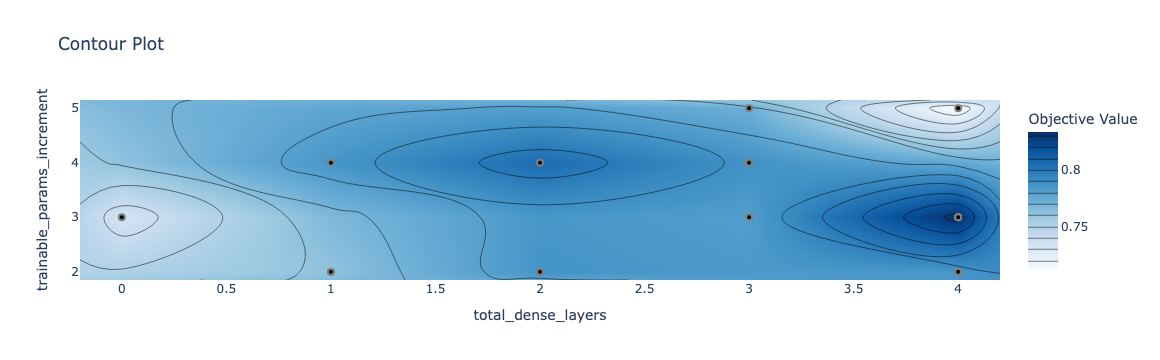

In [37]:
optuna.visualization.plot_contour(study, params=["trainable_params_increment", "total_dense_layers"])

In [7]:
best_model.summary()

NameError: name 'best_model' is not defined

## Post-train evaluation on saved model and study

Look at size of model

In [42]:
!ls saved_models/cnn_efficientnet -lah | grep _model.h5

-rw-r--r-- 1 root root  25M Nov 14 01:44 best_en_model.h5
-rw-r--r-- 1 root root  28M Nov 14 03:48 best_en_tuned_model.h5


Look at "best_model" history

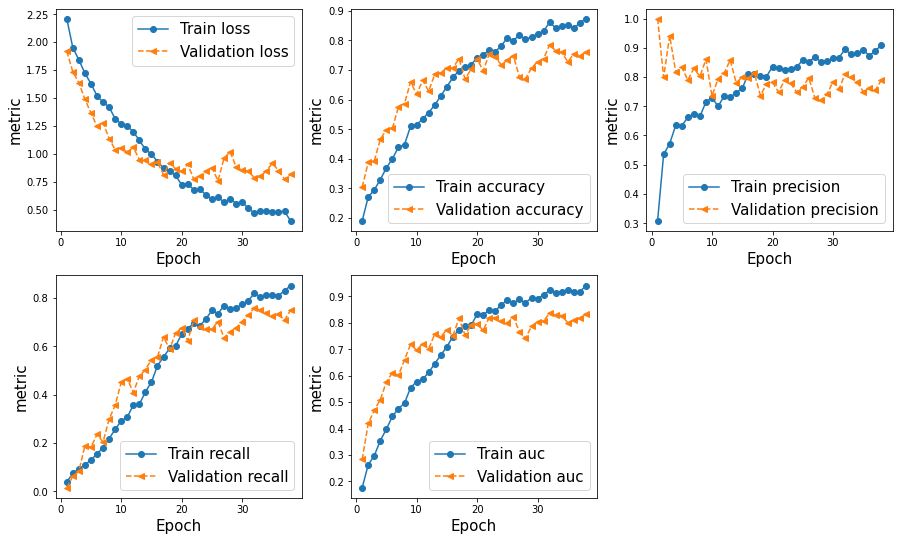

In [46]:
hist = pd.read_csv("saved_models/cnn_efficientnet/best_en_tuned_model_history.csv")
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(15, 9))
for i, metric in enumerate(["loss", "accuracy", "precision", "recall", "auc"]):
    ax = fig.add_subplot(2, 3, i+1)
    ax.plot(x_arr, hist[metric], '-o', label=f'Train {metric}')
    ax.plot(x_arr, hist[f'val_{metric}'], '--<', label=f'Validation {metric}')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('metric', size=15)

Thoughts: noise in validation data might be reduced with a bigger validation dataset (when we look at more than 2000 images).

Look at saved "best_model"

In [ ]:
best_model = tf.keras.models.load_model("saved_models/cnn_efficientnet/best_en_tuned_model.h5")

In [ ]:
best_model.summary()

In [ ]:
best_model.layers[1].summary()

In [ ]:
best_model.layers[2].summary()

Thoughts: there seems to be a lot more Dense layers here than in basic CNN. Need to reconfirm with augmented dataset.

Let's look at what each EfficientNet layer (block) is learning.

Analyze what optuna learned.

In [54]:
loaded_study = joblib.load("saved_models/cnn_efficientnet/no-name-431d0280-4cde-4f72-9cf5-47cf18d215eb.pkl")

In [55]:
loaded_study.best_trials

[FrozenTrial(number=18, values=[0.8334841728210449], datetime_start=datetime.datetime(2022, 11, 14, 3, 44, 17, 300724), datetime_complete=datetime.datetime(2022, 11, 14, 3, 48, 10, 958724), params={'trainable_params_increment': 3, 'total_dense_layers': 4, 'dense_layer_0_dense_units': 23, 'dense_layer_1_dense_units': 13, 'dense_layer_2_dense_units': 11, 'dense_layer_3_dense_units': 26}, distributions={'trainable_params_increment': IntDistribution(high=5, log=False, low=2, step=1), 'total_dense_layers': IntDistribution(high=4, log=False, low=0, step=1), 'dense_layer_0_dense_units': IntDistribution(high=30, log=False, low=5, step=1), 'dense_layer_1_dense_units': IntDistribution(high=30, log=False, low=5, step=1), 'dense_layer_2_dense_units': IntDistribution(high=30, log=False, low=5, step=1), 'dense_layer_3_dense_units': IntDistribution(high=30, log=False, low=5, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=18, state=TrialState.COMPLETE, value=None)]

### Using best model parameters for extended training
What happens when we don't cap our epochs with an early-stopping callback?

In [5]:
loaded_study = joblib.load("saved_models/cnn_efficientnet/no-name-431d0280-4cde-4f72-9cf5-47cf18d215eb.pkl")

In [6]:
loaded_study.best_trial.params

{'trainable_params_increment': 3,
 'total_dense_layers': 4,
 'dense_layer_0_dense_units': 23,
 'dense_layer_1_dense_units': 13,
 'dense_layer_2_dense_units': 11,
 'dense_layer_3_dense_units': 26}

In [7]:
# Recompile model with more metrics
tf.keras.backend.clear_session()
model = tf.keras.models.load_model("saved_models/cnn_efficientnet/best_en_tuned_model.h5")
model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.metrics.Precision(),
        tf.metrics.Recall(),
        tf.keras.metrics.AUC(curve="PR", name="auc_pr"),
        tf.keras.metrics.AUC(curve="ROC", name="auc_roc"),
        tfa.metrics.F1Score(num_classes=8),
    ],
)
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=50,
    batch_size=32,
    # callbacks=callbacks,
    verbose=1,
)
print("Done extended training")

Epoch 1/50
Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-11-14 06:00:22.875 tensorflow-2-6-gpu--ml-g4dn-xlarge-0dac2104acc07d6f4758a14ad24a:33 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-11-14 06:00:22.901 tensorflow-2-6-gpu--ml-g4dn-xlarge-0dac2104acc07d6f4758a14ad24a:33 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
54/54 [==============================] - 21s 198ms/step - loss: 0.9263 - accuracy: 0.7350 - precision: 0.7785 - recall: 0.6984 - auc_pr: 0.7874 - auc_roc: 0.9403 - f1_score: 0.7357 - val_loss: 1.1008 - val_accuracy: 0.6859 - val_precision: 0.7135 - val_recall: 0.6387 - val_auc_pr: 0.7352 - val_auc_

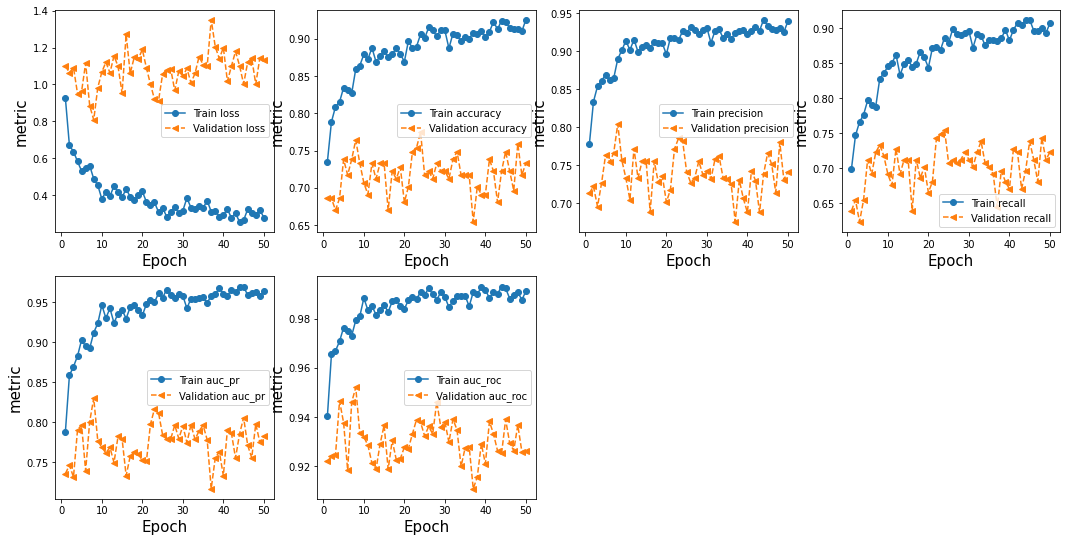

In [17]:
history_df = pd.DataFrame(history.history)
x_arr = np.arange(len(history_df['loss'])) + 1

fig = plt.figure(figsize=(18, 9))
for i, metric in enumerate(["loss", "accuracy", "precision", "recall", "auc_pr", "auc_roc"]):
    ax = fig.add_subplot(2, 4, i+1)
    ax.plot(x_arr, history_df[metric], '-o', label=f'Train {metric}')
    ax.plot(x_arr, history_df[f'val_{metric}'], '--<', label=f'Validation {metric}')
    ax.legend(fontsize=10)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('metric', size=15)

Turns out EarlyStopping is pretty good -- there's no marked improvement in validation data set past the initial stopping point.